In [1]:
import pandas as pd
from pathlib import Path

from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve,RepeatedKFold

from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.special import boxcox1p
from sklearn.linear_model import Lasso

from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,PowerTransformer
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler

from sklearn.manifold import TSNE

%matplotlib inline

In [2]:

#dataframe final
df_final = pd.read_csv("../data/DF_train15noChangeContact_skempiAB_modeller_final.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns
df_final.shape

(1392, 78)

In [3]:
# Split train and independent test data

X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG_exp',axis=1), df_final['ddG_exp'], 
                                                    test_size=0.2, random_state=13)                                               

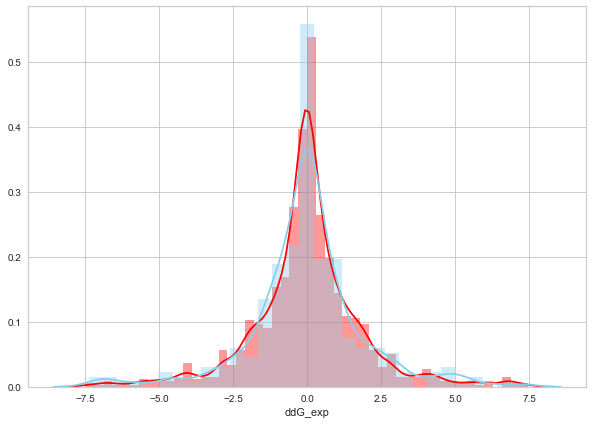

In [4]:
f, ax = plt.subplots(figsize=(10, 7))

sns.distplot(y_train, color="red", label="ddG_exp_train");
sns.distplot(y_test, color="skyblue", label="ddG_exp_test");



 mu = 0.00 and sigma = 1.88



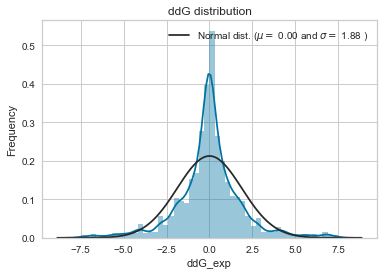

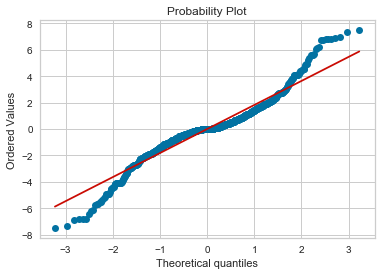

In [5]:
sns.distplot(y_train, fit=stats.norm);

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ddG distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

# probably need to transform target variable

## Correlation

In [6]:
# join train data for Exploratory analisis of training data
train = X_train.join(y_train)

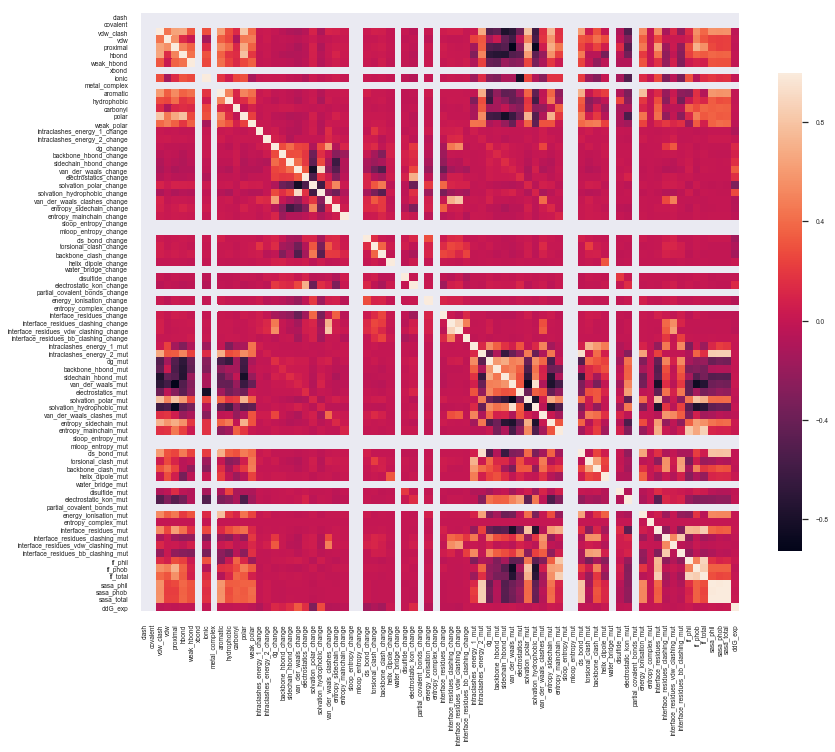

In [7]:
sns.set(font_scale=0.6)

#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corrmat, square=True,cbar_kws={"shrink": .8});
#plt.savefig("Train15_initCorr.png",dpi=600,bbox_inches="tight")

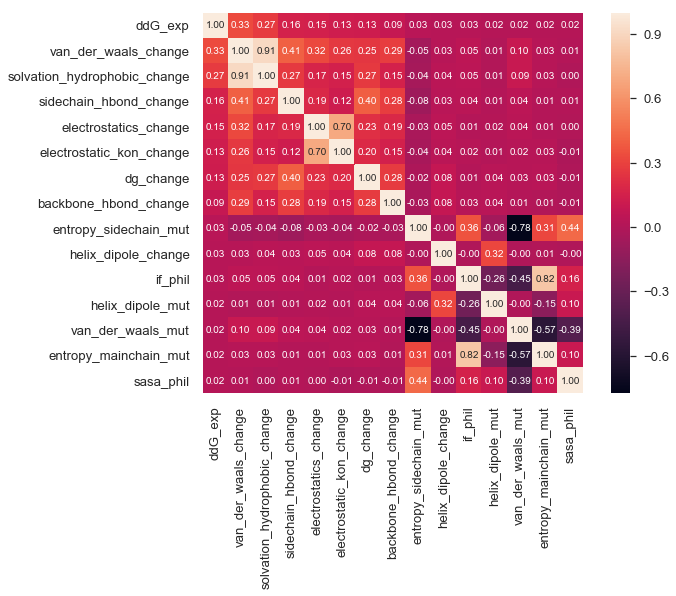

In [8]:
sns.set(font_scale=1.2)


#top 10. correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ddG_exp')['ddG_exp'].index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);
#plt.savefig("Train15_initCorrTOP15.png",dpi=600,bbox_inches="tight")

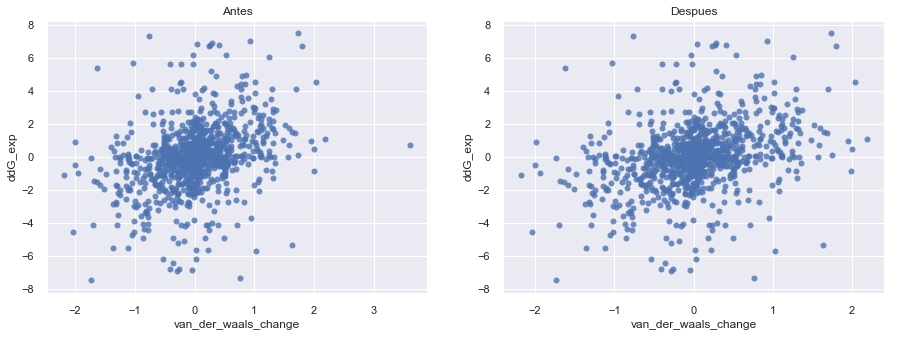

In [7]:
sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG_exp'], fit_reg=False).set_title("Antes")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['van_der_waals_change']>3)].index)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG_exp'], fit_reg=False).set_title("Despues")
#plt.savefig("Train15_outlierVDWchange.png",dpi=600,bbox_inches="tight")

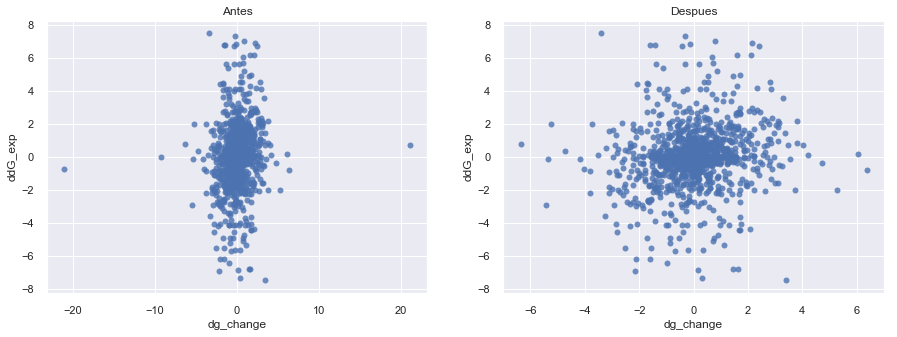

In [8]:
sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['dg_change'], y=train['ddG_exp'], fit_reg=False).set_title("Antes")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['dg_change'].abs()>8)].index)
g = sns.regplot(x=train['dg_change'], y=train['ddG_exp'], fit_reg=False).set_title("Despues")
#plt.savefig("Train15_outlierDgchange.png",dpi=600,bbox_inches="tight")

### NO missing values, skip this dataprocess

## 

### Feature engeenering, checking interaction of sift contact with the highest correlated energetic feature
In order to treat this dataset, first I will check if adding interactions betwen some features improve corr, next i will check for skewess features. Finally i will write a custom transform class for every step.

In [9]:
y_train = train['ddG_exp']
X_train = train.drop('ddG_exp',axis=1)

### Check corr of new features

In [12]:
features_interaction_contactVDW = X_train.iloc[:,:15].mul(X_train["van_der_waals_change"],axis=0)# funciona mucho mejor
features_interaction_contactVDW.columns = features_interaction_contactVDW.columns.str[:]+"_vdw_change_interaction"


In [13]:
corr_matrix = features_interaction_contactVDW.corrwith(y_train,axis=0)#.abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
print(corr_matrix.sort_values(ascending=False).round(6))

hbond_vdw_change_interaction            0.364546
polar_vdw_change_interaction            0.349457
weak_polar_vdw_change_interaction       0.347648
vdw_clash_vdw_change_interaction        0.346148
weak_hbond_vdw_change_interaction       0.341377
proximal_vdw_change_interaction         0.331598
hydrophobic_vdw_change_interaction      0.295767
vdw_vdw_change_interaction              0.295753
ionic_vdw_change_interaction            0.252295
aromatic_vdw_change_interaction         0.239054
carbonyl_vdw_change_interaction         0.209229
clash_vdw_change_interaction                 NaN
covalent_vdw_change_interaction              NaN
xbond_vdw_change_interaction                 NaN
metal_complex_vdw_change_interaction         NaN
dtype: float64


### Check skewness

In [14]:
skew_features = X_train.skew().sort_values(ascending=False)
skew_features

interface_residues_vdw_clashing_mut      6.886928
cis_bond_mut                             2.963595
intraclashes_energy_2_mut                2.953448
interface_residues_bb_clashing_mut       2.902191
interface_residues_clashing_mut          2.566482
sasa_phob                                1.963085
sasa_total                               1.942088
energy_ionisation_mut                    1.862720
sasa_phil                                1.838843
van_der_waals_clashes_change             1.638112
torsional_clash_mut                      1.624876
aromatic                                 1.595366
if_phil                                  1.488984
carbonyl                                 1.362180
entropy_mainchain_mut                    1.285913
vdw_clash                                1.281802
van_der_waals_clashes_mut                1.218391
if_total                                 1.164993
intraclashes_energy_1_mut                1.084688
energy_ionisation_change                 0.826565


### Check features by percetange of zero values

In [15]:
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 >90.:
        overfit.append(i)
overfit

['clash',
 'covalent',
 'xbond',
 'metal_complex',
 'sloop_entropy_change',
 'mloop_entropy_change',
 'cis_bond_change',
 'water_bridge_change',
 'partial_covalent_bonds_change',
 'entropy_complex_change',
 'interface_residues_clashing_change',
 'interface_residues_vdw_clashing_change',
 'interface_residues_bb_clashing_change',
 'sloop_entropy_mut',
 'mloop_entropy_mut',
 'water_bridge_mut',
 'partial_covalent_bonds_mut',
 'entropy_complex_mut',
 'interface_residues_vdw_clashing_mut']

### make custom transformer for preprocess in pipeline

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesInteractions(BaseEstimator, TransformerMixin):
    
    #Class constructor method that takes ..
    def __init__(self, interaction1, interaction2 ):
        self.interaction1 = interaction1
        self.interaction2 = interaction2
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        
        return self
    
    def transform(self, X , y=None ):
        
        X_interactions = X.loc[:,self.interaction1].mul(X[self.interaction2],axis=0)
        X_interactions.columns = X_interactions.columns.values+'/{}'.format(self.interaction2)
        # set columns names
        
        X = X.join(X_interactions)
        
        return X
    
class SkewTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.6, method='quantile'):
        self.threshold = threshold
        self.method = method
        
    #Return self nothing else to do here
    def fit(self, X, y = None  ):
        skewes_ = X.skew().sort_values(ascending=False)
        self.skew_features = skewes_[skewes_.abs() > self.threshold]
        
        if self.method == 'quantile':
            self.t = QuantileTransformer(output_distribution="normal",random_state=13)
            self.t.fit(X[self.skew_features.index])
        
        return self
    
    def transform(self, X, y=None):
        
        X[self.skew_features.index] = self.t.transform(X[self.skew_features.index])
        
        return X
        
class ZeroThreshold(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=90.):
        self.threshold = threshold
    
    
    def fit(self, X, y = None  ):
        
        self.feature_names = X.columns
        self.overfit = []
        for i in X.columns:
            counts = X[i].value_counts()
            zeros = counts.iloc[0]
            if zeros / len(X) * 100 >self.threshold:
                self.overfit.append(i)
        
        return self
    
    def transform(self, X, y=None):
        
        X.drop(self.overfit,axis=1,inplace=True)
        
        return X


    
    

# Modeling

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1109, 77), (1109,), (279, 77), (279,))

KeyboardInterrupt: 

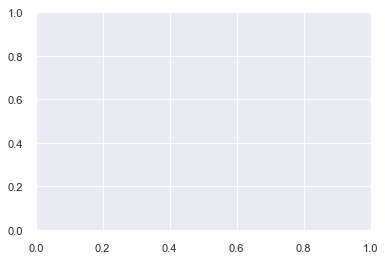

In [14]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve


## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)


#2)
rf_model = GradientBoostingRegressor(n_estimators=50)
#3) Crear pipeline
#pipeline1 = make_pipeline(scale,selector,fselec, rf_model)
pipeline1 = make_pipeline(interactions,skewness,zeroth, rf_model)


cv = RepeatedKFold(n_splits=10,n_repeats=2,random_state=13)

# Extract the instances and target
viz = ValidationCurve(
    pipeline1, njobs=-1,param_name="gradientboostingregressor__subsample",
    param_range=[0.3,0.4,0.5,0.6,0.7], cv=cv, scoring="neg_mean_squared_error"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()


In [150]:
GradientBoostingRegressor?

In [57]:
#1)  ORIGINAL
## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)


#2)
rf_model = GradientBoostingRegressor(random_state=13)
#3) Crear pipeline
#pipeline1 = make_pipeline(interactions,skewness, zeroth, rf_model)
pipeline1 = make_pipeline(interactions,skewness,zeroth, rf_model)

# Use transformed target regressor
# regr_trans = TransformedTargetRegressor(regressor=pipeline1, 
#                                         transformer=PowerTransformer(output_distribution='normal',random_state=13))


# # grid params
# param_grid = {
#     'regressor__gradientboostingregressor__max_depth': [9],
#     'regressor__gradientboostingregressor__max_features': ['sqrt'],
#     'regressor__gradientboostingregressor__min_samples_leaf': [21],
#     'regressor__gradientboostingregressor__min_samples_split': [2],
#     'regressor__gradientboostingregressor__n_estimators': [200],
#     'regressor__gradientboostingregressor__subsample':[0.7],
#     'regressor__gradientboostingregressor__learning_rate':[0.05],
#     'regressor__gradientboostingregressor__loss':["huber"],
#     'regressor__gradientboostingregressor__alpha':[0.4]}

param_grid = {
    'gradientboostingregressor__max_depth': [6],
    'gradientboostingregressor__max_features': ['sqrt'],
    'gradientboostingregressor__min_samples_leaf': [30],
    'gradientboostingregressor__min_samples_split': [2],
    'gradientboostingregressor__n_estimators': [100],
    'gradientboostingregressor__subsample':[0.8],
    'gradientboostingregressor__learning_rate':[0.05],
    'gradientboostingregressor__loss':["huber"],
    'gradientboostingregressor__alpha':[0.9]}
    
cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid1 = GridSearchCV(pipeline1, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid1.fit(X_train,y_train)

Fitting 100 folds for each of 1 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:   11.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a1be68630>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interaction2='van_der_waals_change')), ('skewtra...=13, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gradientboostingregressor__max_depth': [6], 'gradientboostingregressor__max_features': ['sqrt'], 'gradientboostingregressor__min_samples_leaf': [30], 'gradientboostingregressor__min_samples_split': [2], 'gradientboostingregressor__n_estimators': [100], 'gradientboostingregressor__subsample': [0.8], 'gradientboostingregressor__learning_rate': [0.05], 'gra

In [58]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.629430 +/- 0.799343
CV train RMSE 1.278502 +/- 0.225925
DIFF RMSE 0.35092797677433385
CV test r2 0.243458 +/- 0.079707
CV train r2 0.537599 +/- 0.009211
0.29414037095192286
 {'gradientboostingregressor__alpha': 0.9, 'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_depth': 6, 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_leaf': 30, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__n_estimators': 100, 'gradientboostingregressor__subsample': 0.8}

RMSE for test dataset: 1.64
RMSE for train dataset: 1.29
pearson corr  0.591408
R2 test 0.3178301850116666
R2 train 0.5310086844583202


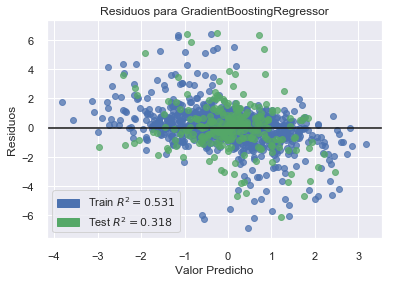

In [61]:
visualizer = ResidualsPlot(grid1.best_estimator_,title='Residuos para GradientBoostingRegressor',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

plt.savefig("GBT_R2_train15.png",dpi=600,bbox_inches="tight")
#visualizer.poof()                 # Draw/show/poof the data

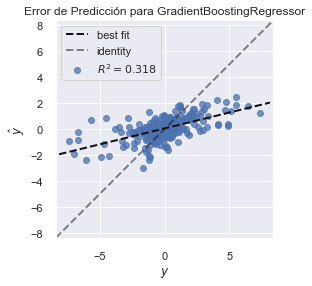

In [62]:
perror = PredictionError(grid1.best_estimator_, title='Error de Predicción para GradientBoostingRegressor')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("GBT_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()

In [63]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

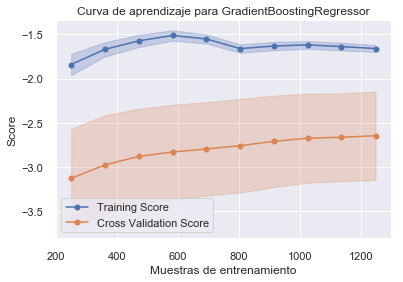

In [64]:

viz = LearningCurve(grid1.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para GradientBoostingRegressor')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("GBT_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

In [65]:
print("RMSE CV Train {}".format(np.sqrt(-viz.train_scores_mean_[-1])))
print("RMSE CV Test {}".format(np.sqrt(-viz.test_scores_mean_[-1])))

RMSE CV Train 1.2886502465011969
RMSE CV Test 1.6266252176339535


In [90]:
np.sqrt(viz.test_scores_std_)

array([0.74804027, 0.7488742 , 0.73419894, 0.73055482, 0.72695524,
       0.72686868, 0.7187431 , 0.70904132, 0.70455176, 0.70763023])

In [66]:
final_gbt = grid1.best_estimator_.fit(full_data,y_full)

In [67]:
# save final model

joblib.dump(final_gbt, 'GBTmodel_train15skempiAB_FINAL.overf.pkl')

['GBTmodel_train15skempiAB_FINAL.overf.pkl']

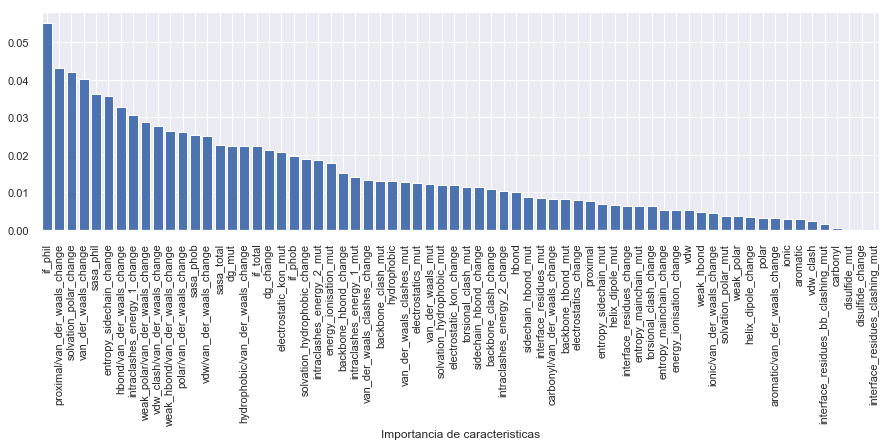

In [84]:
feature_importance = final_gbt.named_steps['gradientboostingregressor'].feature_importances_
#feature_importance = feature_importance * 100.0 # * (feature_importance / feature_importance.max())

idx_features = feature_importance.argsort()[::-1]

fnames = final_gbt.named_steps.zerothreshold.feature_names.drop(final_gbt.named_steps.zerothreshold.overfit)
plt.figure(figsize=(15,4))

plt.bar(np.arange(len(fnames)), feature_importance[idx_features])
plt.xticks(range(len(fnames)),fnames[idx_features],rotation=90)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel(u"Importancia de caracteristicas")
plt.savefig("GBT",dpi=600,bbox_inches="tight")

In [89]:
importances = list(final_gbt.named_steps['gradientboostingregressor'].feature_importances_)
feature_list = fnames
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: if_phil              Importance: 0.0552
Variable: proximal/van_der_waals_change Importance: 0.0432
Variable: solvation_polar_change Importance: 0.0421
Variable: van_der_waals_change Importance: 0.0401
Variable: sasa_phil            Importance: 0.0363
Variable: entropy_sidechain_change Importance: 0.0358
Variable: hbond/van_der_waals_change Importance: 0.0327
Variable: intraclashes_energy_1_change Importance: 0.0307
Variable: weak_polar/van_der_waals_change Importance: 0.0288
Variable: vdw_clash/van_der_waals_change Importance: 0.0277
Variable: weak_hbond/van_der_waals_change Importance: 0.0264
Variable: polar/van_der_waals_change Importance: 0.026
Variable: sasa_phob            Importance: 0.0253
Variable: vdw/van_der_waals_change Importance: 0.025
Variable: sasa_total           Importance: 0.0226
Variable: dg_mut               Importance: 0.0225
Variable: hydrophobic/van_der_waals_change Importance: 0.0225
Variable: if_total             Importance: 0.0224
Variable: dg_change

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Salvar modelo final, entrenado con el total de lso datos

Text(4.5, -0.5, 'RMSE = 1.645')

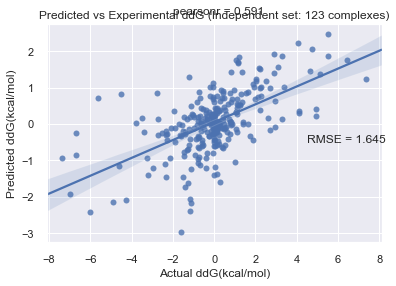

In [85]:
rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
df_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_test_pred, "Actual ddG(kcal/mol)": y_test.values.ravel()})
pearsonr_test = round(df_pred.corr().iloc[0,1],3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_pred)
plt.title("Predicted vs Experimental ddG (Independent set: 123 complexes)")

plt.text(-2,3,"pearsonr = %s" %pearsonr_test)
plt.text(4.5,-0.5,"RMSE = %s" %rmse_test)

#plt.savefig("RFmodel_300_testfit.png",dpi=600)

Text(0.5, 1.0, 'Predicted vs Experimental ddG (Train set: 492 complexes)')

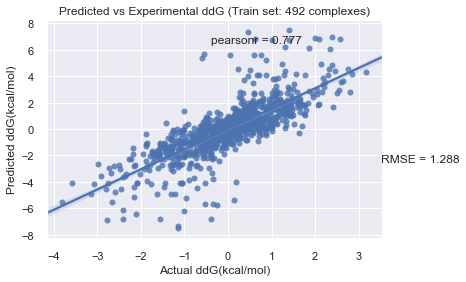

In [86]:
df_train_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_train.values.ravel(), "Actual ddG(kcal/mol)": y_train_pred})
pearsonr_train = round(df_train_pred.corr().iloc[0,1],3)
rmse_train = np.round(np.sqrt(mean_squared_error(y_train.values.ravel(), y_train_pred)), 3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_train_pred)

plt.text(-0.4,6.5,"pearsonr = %s" %pearsonr_train)
plt.text(3.5,-2.5,"RMSE = %s" %rmse_train)
plt.title("Predicted vs Experimental ddG (Train set: 492 complexes)")
#plt.savefig("RFmodel_300_trainfit.png",dpi=600)


In [86]:
rf_model = grid1.best_estimator_.named_steps["randomforestregressor"]
importances = list(rf_model.feature_importances_)
feature_list = df_final.columns
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: dg_change            Importance: 0.0632
Variable: van_der_waals_change Importance: 0.0571
Variable: solvation_polar_change Importance: 0.056
Variable: helix_dipole_wt      Importance: 0.0362
Variable: torsional_clash_change Importance: 0.0325
Variable: sidechain_hbond_change Importance: 0.031
Variable: backbone_clash_change Importance: 0.031
Variable: solvation_hydrophobic_change Importance: 0.0304
Variable: backbone_hbond_change Importance: 0.03
Variable: if_phil              Importance: 0.0288
Variable: if_total             Importance: 0.0263
Variable: van_der_waals_clashes_change Importance: 0.0257
Variable: intraclashes_energy_1_change Importance: 0.0256
Variable: van_der_waals_clashes_wt Importance: 0.0254
Variable: dg_wt                Importance: 0.0252
Variable: sasa_phil_mut        Importance: 0.0249
Variable: intraclashes_energy_1_wt Importance: 0.0242
Variable: torsional_clash_wt   Importance: 0.0226
Variable: hbond                Importance: 0.019
Variable: energy

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [23]:
RepeatedKFold?

In [157]:
# Algorithms used for modeling
from sklearn.linear_model import ElasticNetCV, LassoCV, BayesianRidge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVR

import xgboost as xgb
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

ridge = make_pipeline(MinMaxScaler(), RidgeCV(alphas=alphas_alt, cv=cv))
lasso = make_pipeline(MinMaxScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=cv))
elasticnet = make_pipeline(MinMaxScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=cv, l1_ratio=e_l1ratio))                                
svr = make_pipeline(MinMaxScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
gb = make_pipeline(GradientBoostingRegressor())
bayesianridge = make_pipeline(MinMaxScaler(),BayesianRidge())
rf = make_pipeline(RandomForestRegressor())
xgbr = make_pipeline(xgb.XGBRegressor())

#Machine Learning Algorithm (MLA) Selection and Initialization
models = [ridge, elasticnet, lasso, gb, bayesianridge, rf, xgbr]

# First I will use ShuffleSplit as a way of randomising the cross validation samples.
cvr = RepeatedKFold(n_splits=10,n_repeats=5,random_state=13)

#create table to compare MLA metrics
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

#index through models and save performance to table
row_index = 0
for alg in models:

    #set name and parameters
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, y_train.values.ravel())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    training_results = np.sqrt((-cross_val_score(alg, X_train, y_train.values.ravel(), cv = cvr, scoring= 'neg_mean_squared_error')).mean())
    #training_results = cross_val_score(alg, X_train, y_train, cv = shuff, scoring= 'r2').mean()
    test_results = np.sqrt(((y_test.values.ravel()-alg.predict(X_test))**2).mean())
    #test_results = r2_score(y_pred=alg.predict(X_test),y_true=y_test)
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_results)#*100
    before_model_compare.loc[row_index, 'Test Accuracy'] = (test_results)#*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1 Pipeline trained...
2 Pipeline trained...
3 Pipeline trained...
4 Pipeline trained...
5 Pipeline trained...


/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


6 Pipeline trained...
7 Pipeline trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,Pipeline,"{'memory': None, 'steps': [('minmaxscaler', Mi...",1.767,1.780
1,Pipeline,"{'memory': None, 'steps': [('minmaxscaler', Mi...",1.758,1.723
2,Pipeline,"{'memory': None, 'steps': [('minmaxscaler', Mi...",1.758,1.723
3,Pipeline,"{'memory': None, 'steps': [('gradientboostingr...",1.688,1.679
4,Pipeline,"{'memory': None, 'steps': [('minmaxscaler', Mi...",1.765,1.761
5,Pipeline,"{'memory': None, 'steps': [('randomforestregre...",1.728,1.720
6,Pipeline,"{'memory': None, 'steps': [('xgbregressor', XG...",1.669,1.709
